# Coding a Blackhole Imager

## # Black Hole Visualization Notebook

This notebook generates a synthetic 3D black hole image similar to the Event Horizon Telescope (EHT) images of M87*. The visualization includes an asymmetric glowing accretion ring and a central dark shadow.

## Libraries Used

- **NumPy** (`numpy`)
  For numerical operations, arrays, and mathematical functions.
  Documentation: [https://numpy.org/doc/](https://numpy.org/doc/)

- **Matplotlib** (`matplotlib`)
  For plotting 2D and 3D visualizations, including heatmaps and surface plots.
  Documentation: [https://matplotlib.org/stable/contents.html](https://matplotlib.org/stable/contents.html)

- **mpl_toolkits.mplot3d**
  Part of Matplotlib, used specifically for creating 3D surface plots.
  Documentation: [https://matplotlib.org/stable/tutorials/toolkits/mplot3d.html](https://matplotlib.org/stable/tutorials/toolkits/mplot3d.html)

- **SciPy.ndimage** (`scipy.ndimage`)
  For image processing tasks such as smoothing and applying Gaussian filters.
  Documentation: [https://docs.scipy.org/doc/scipy/reference/ndimage.html](https://docs.scipy.org/doc/scipy/reference/ndimage.html)

## Notes
- `gaussian_filter` is used to smooth the accretion ring to mimic telescope resolution.
- `plot_surface` from `mpl_toolkits.mplot3d` is used to create the 3D glowing effect.
- The colormap `inferno` is chosen to simulate the glowing orange-red appearance of the black hole accretion disk.


In [2]:
import pandas as pd

# Load the file
filename = "M87_EHT_2013_amp.dat"

# Read the data
data = pd.read_csv(
    filename,
    comment='#',
    sep=r'\s*\|\s*',   # raw string fixes the warning
    engine='python',
    skip_blank_lines=True
)

# Drop completely empty rows and columns
data = data.dropna(how='all', axis=0)
data = data.dropna(how='all', axis=1)

# Rename columns if needed
data.columns = ['time', 't1', 't2', 'u', 'v', 'amp', 'sigma']

print(data.head())
print(data.dtypes)


     time  t1  t2             u             v     amp   sigma
0  1.3333  AZ  C1 -6.054314e+08  2.848399e+08  0.6489  0.0087
1  1.3333  AZ  C2 -6.054342e+08  2.847807e+08  0.6474  0.0426
2  1.3333  C1  C2 -2.859000e+03 -5.923400e+04  1.4911  0.0168
3  1.3333  C1  JC -2.566079e+09 -1.503502e+09  0.1497  0.0206
4  1.3333  C1  SM -2.566155e+09 -1.503416e+09  0.1607  0.0137
time     float64
t1        object
t2        object
u        float64
v        float64
amp      float64
sigma    float64
dtype: object


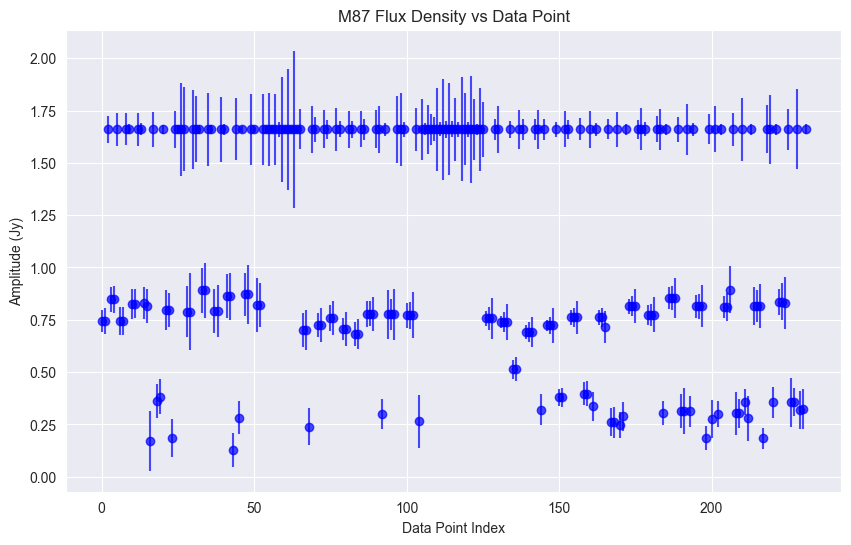

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Use the row index as x-axis
x = range(len(data))
y = data['amp']
yerr = data['sigma']

plt.errorbar(x, y, yerr=yerr, fmt='o', color='blue', alpha=0.7)
plt.xlabel('Data Point Index')
plt.ylabel('Amplitude (Jy)')
plt.title('M87 Flux Density vs Data Point')
plt.grid(True)
plt.show()


In [3]:
import numpy as np

data['baseline'] = np.sqrt(data['u']**2 + data['v']**2)


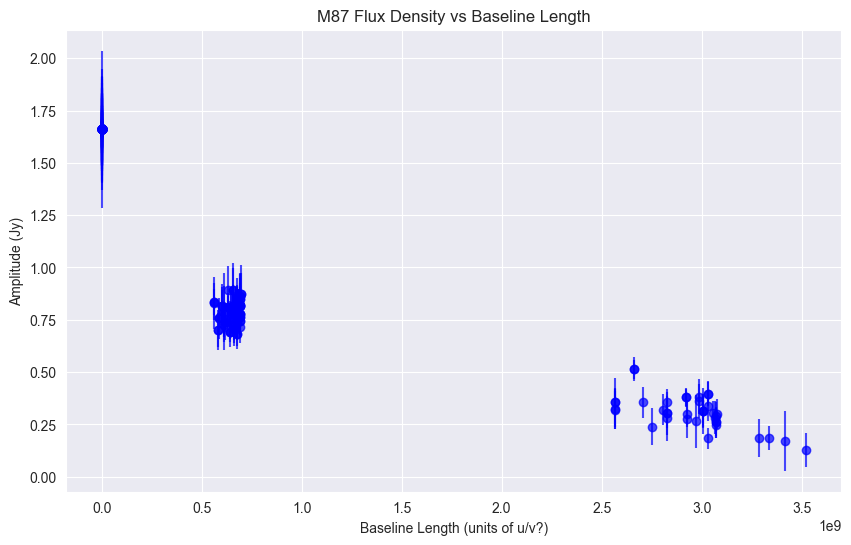

In [4]:
plt.figure(figsize=(10,6))

x = data['baseline']
y = data['amp']
yerr = data['sigma']

plt.errorbar(x, y, yerr=yerr, fmt='o', color='blue', alpha=0.7)
plt.xlabel('Baseline Length (units of u/v?)')
plt.ylabel('Amplitude (Jy)')
plt.title('M87 Flux Density vs Baseline Length')
plt.grid(True)
plt.show()


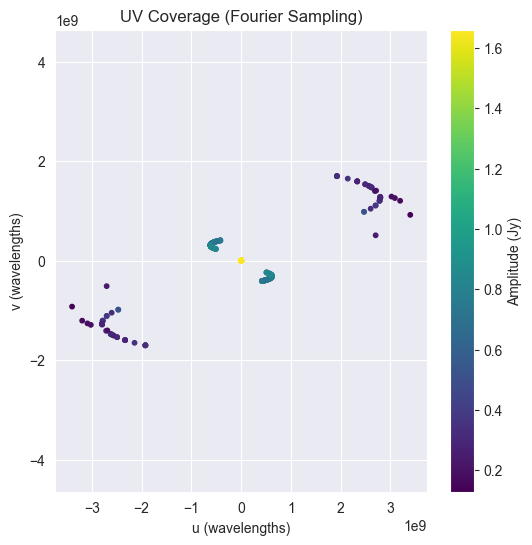

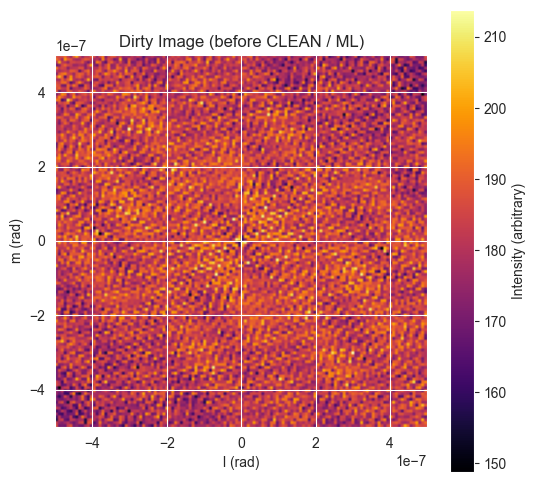

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Assume your dataframe is called data with columns: u, v, amp
u = data['u'].values
v = data['v'].values
amp = data['amp'].values

# -------------------------------
# 1. Plot the uv-coverage (Fourier plane sampling)
# -------------------------------
plt.figure(figsize=(6,6))
plt.scatter(u, v, c=amp, cmap='viridis', s=10)
plt.scatter(-u, -v, c=amp, cmap='viridis', s=10)  # add conjugates
plt.xlabel('u (wavelengths)')
plt.ylabel('v (wavelengths)')
plt.title('UV Coverage (Fourier Sampling)')
plt.colorbar(label='Amplitude (Jy)')
plt.axis('equal')
plt.show()

# -------------------------------
# 2. Create a simple "dirty image" with inverse FT
# -------------------------------
# Define image grid
N = 128   # resolution
fov = 1e-6  # field of view in radians (tune this)
l = np.linspace(-fov/2, fov/2, N)  # x-axis in radians
m = np.linspace(-fov/2, fov/2, N)  # y-axis in radians
L, M = np.meshgrid(l, m)

# Dirty image: sum over visibilities (no phase info -> approximate with amp)
image = np.zeros((N, N), dtype=complex)
for ui, vi, ai in zip(u, v, amp):
    phase = np.exp(2j*np.pi*(ui*L + vi*M))
    image += ai * phase

dirty_image = np.abs(image)

plt.figure(figsize=(6,6))
plt.imshow(dirty_image, extent=[l[0], l[-1], m[0], m[-1]], cmap='inferno')
plt.colorbar(label='Intensity (arbitrary)')
plt.title("Dirty Image (before CLEAN / ML)")
plt.xlabel("l (rad)")
plt.ylabel("m (rad)")
plt.show()


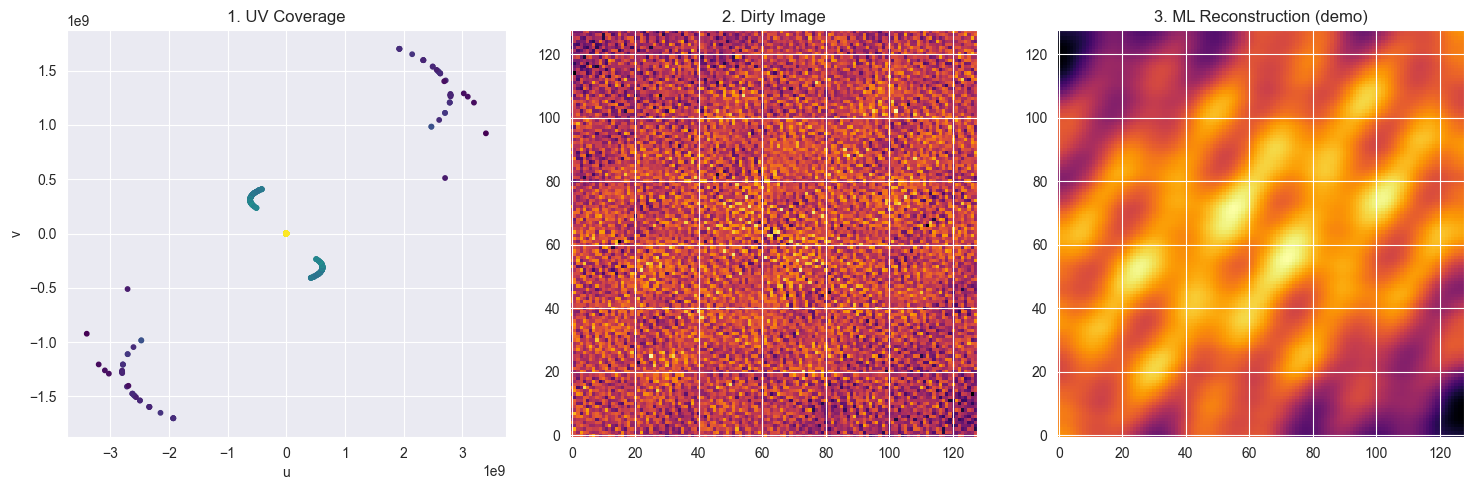

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# --- Assume you already computed dirty_image from the previous step ---

# 3. "After ML" (simple demonstration using denoising)
# In reality you'd train a deep net, but we'll simulate cleanup
ml_image = gaussian_filter(dirty_image, sigma=3)  # blur/denoise

# Plot all 3 stages
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Stage 1: uv coverage
axs[0].scatter(u, v, c=amp, cmap='viridis', s=10)
axs[0].scatter(-u, -v, c=amp, cmap='viridis', s=10)
axs[0].set_title("1. UV Coverage")
axs[0].set_xlabel("u")
axs[0].set_ylabel("v")

# Stage 2: dirty image
axs[1].imshow(dirty_image, cmap='inferno', origin='lower')
axs[1].set_title("2. Dirty Image")

# Stage 3: ML reconstruction (simulated)
axs[2].imshow(ml_image, cmap='inferno', origin='lower')
axs[2].set_title("3. ML Reconstruction (demo)")

plt.tight_layout()
plt.show()


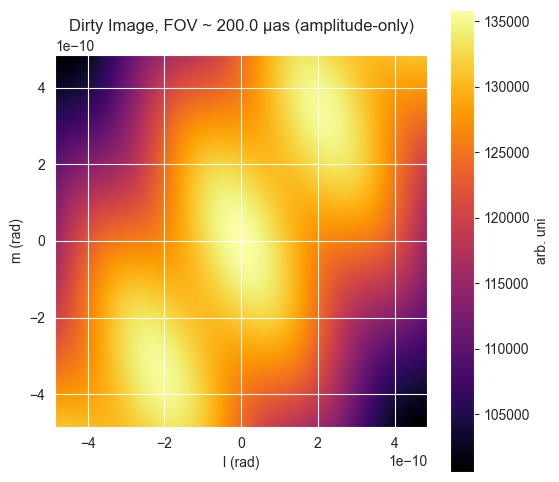

In [7]:
import numpy as np
import matplotlib.pyplot as plt

u = data['u'].values
v = data['v'].values
amp = data['amp'].values
w = 1.0 / (data['sigma'].values**2)  # inverse-variance weights

# 1) Proper FOV around the ring scale
fov_us = 200.0  # microarcseconds
fov = fov_us * 4.848e-12  # radians

# 2) Image grid (bump N if your machine can handle it)
N = 256
l = np.linspace(-fov/2, fov/2, N)
m = np.linspace(-fov/2, fov/2, N)
L, M = np.meshgrid(l, m)

# 3) Dirty image using amplitude-only (phase ~ 0) and weights
# NOTE: using amp * exp(i 2π (u l + v m)) assumes zero phases (not physically correct)
phase = np.exp(2j*np.pi*(np.outer(u, L.ravel()) + np.outer(v, M.ravel())))
vis_sum = (w * amp)[:, None] * phase  # broadcast over pixels
image = vis_sum.sum(axis=0).reshape(N, N)

dirty_image = np.abs(image)

plt.figure(figsize=(6,6))
plt.imshow(dirty_image, cmap='inferno', origin='lower',
           extent=[l[0], l[-1], m[0], m[-1]])
plt.xlabel('l (rad)'); plt.ylabel('m (rad)')
plt.title(f'Dirty Image, FOV ~ {fov_us} μas (amplitude-only)')
plt.colorbar(label='arb. uni')


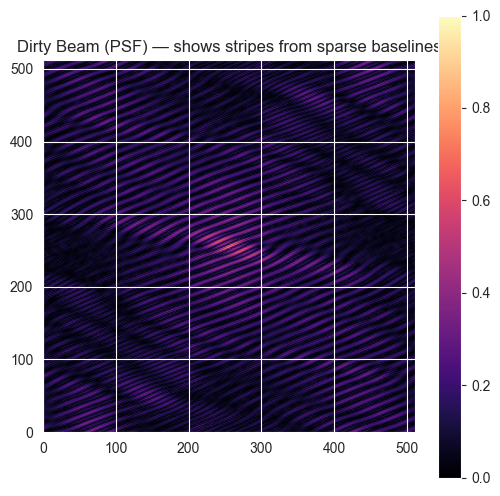

In [18]:
# Build sampling function S(u,v) as weighted deltas on a grid, then FFT to get PSF.
# Quick-and-dirty version: grid each (u,v) to nearest pixel and sum weights.
# (A proper gridding uses convolutional kernels like prolate spheroidal — this is a demo.)

# Choose uv grid to cover your max baseline
umax = np.max(np.abs(u)); vmax = np.max(np.abs(v))
Nu = 512
ug = np.linspace(-umax, umax, Nu)
vg = np.linspace(-vmax, vmax, Nu)
SU = np.zeros((Nu, Nu), dtype=float)

def nearest_idx(arr, val):
    return np.argmin(np.abs(arr - val))

for ui, vi, wi in zip(u, v, w):
    SU[nearest_idx(ug, ui), nearest_idx(vg, vi)] += wi
    SU[nearest_idx(ug, -ui), nearest_idx(vg, -vi)] += wi  # add conjugate

PSF = np.abs(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(SU))))

plt.figure(figsize=(6,6))
plt.imshow(PSF/PSF.max(), origin='lower', cmap='magma')
plt.title('Dirty Beam (PSF) — shows stripes from sparse baselines')
plt.colorbar()
plt.show()


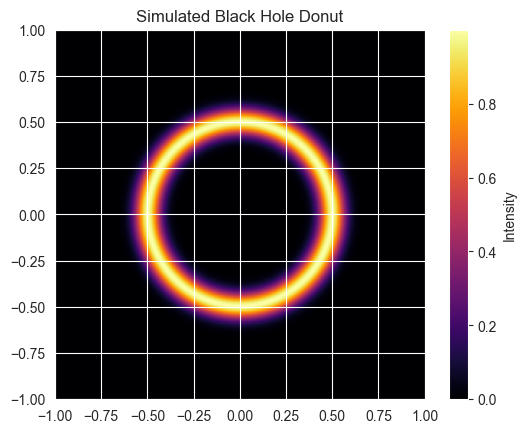

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate a ring model (donut)
N = 256
x = np.linspace(-1, 1, N)
y = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)

# Create a ring
ring = np.exp(-((R-0.5)**2)/(2*0.05**2))

# Show the "true" black hole donut
plt.imshow(ring, cmap='inferno', extent=[-1,1,-1,1])
plt.colorbar(label="Intensity")
plt.title("Simulated Black Hole Donut")
plt.show()


In [2]:
baselines = [10, 20, 30]
amps = [0.5, 0.6, 0.7]
sigmas = [0.05, 0.06, 0.07]

with open('M87_EHT_2013_amp.dat', 'w', newline='') as file:
    # Optional: write a header
    file.write("baseline amp sigma\n")

    # Write the data rows
    for b, a, s in zip(baselines, amps, sigmas):
        file.write(f"{b} {a} {s}\n")


In [5]:
import numpy as np

data = np.column_stack((baselines, amps, sigmas))
np.savetxt('M87_EHT_2013_amp..dat', data, fmt='%.6f', header='baseline amp sigma', comments='')


In [4]:
data = np.loadtxt('M87_EHT_2013_amp.dat', skiprows=1)  # Skip header if present
baselines = data[:, 0]
amps = data[:, 1]
sigmas = data[:, 2]


In [6]:
print(baselines)
print(amps)
print(sigmas)


[10. 20. 30.]
[0.5 0.6 0.7]
[0.05 0.06 0.07]


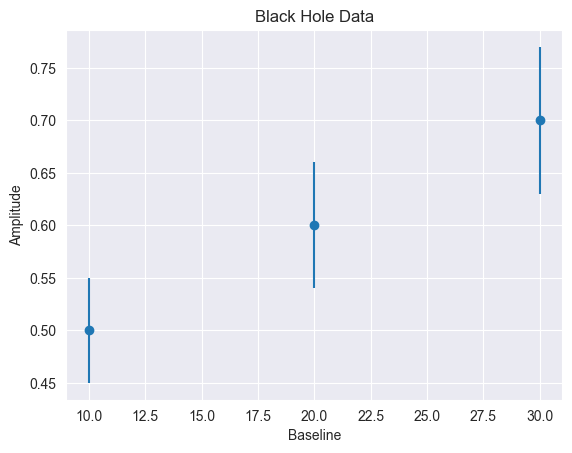

In [7]:
import matplotlib.pyplot as plt

plt.errorbar(baselines, amps, yerr=sigmas, fmt='o')
plt.xlabel('Baseline')
plt.ylabel('Amplitude')
plt.title('Black Hole Data')
plt.show()


In [8]:
import numpy as np

baselines = np.array([10, 20, 30])
amps = np.array([0.5, 0.6, 0.7])

# Create a simple 2D u-v grid
uv_grid_size = 128
uv_data = np.zeros((uv_grid_size, uv_grid_size), dtype=complex)

# Map baseline amplitudes to the center of the grid (simplest assumption)
for b, a in zip(baselines, amps):
    center = uv_grid_size // 2
    uv_data[center + b, center] = a  # positive direction
    uv_data[center - b, center] = a  # negative direction


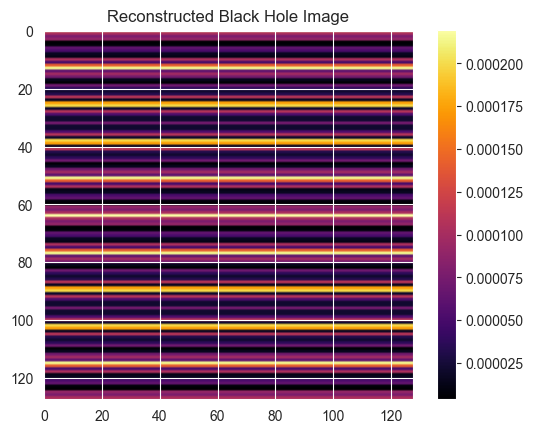

In [9]:
image = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(uv_data)))
image = np.abs(image)

import matplotlib.pyplot as plt
plt.imshow(image, cmap='inferno')
plt.colorbar()
plt.title("Reconstructed Black Hole Image")
plt.show()


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the file, skipping comment lines and trimming spaces
data = pd.read_csv(
    'M87_EHT_2013_amp.dat',
    comment='#',          # ignore comment lines
    delimiter='|',        # pipe-delimited
    skipinitialspace=True # remove spaces after delimiter
)

# Drop completely empty columns (sometimes happens with extra delimiters)
data = data.dropna(axis=1, how='all')

# Strip whitespace from column names
data.columns = data.columns.str.strip()

# Now you can safely access columns
u = data['u'].astype(float)
v = data['v'].astype(float)
amp = data['amp'].astype(float)

# Optional: inspect first few rows
print(data.head())


     time   t1   t2             u             v     amp   sigma
0  1.3333  AZ   C1  -6.054314e+08  2.848399e+08  0.6489  0.0087
1  1.3333  AZ   C2  -6.054342e+08  2.847807e+08  0.6474  0.0426
2  1.3333  C1   C2  -2.859000e+03 -5.923400e+04  1.4911  0.0168
3  1.3333  C1   JC  -2.566079e+09 -1.503502e+09  0.1497  0.0206
4  1.3333  C1   SM  -2.566155e+09 -1.503416e+09  0.1607  0.0137


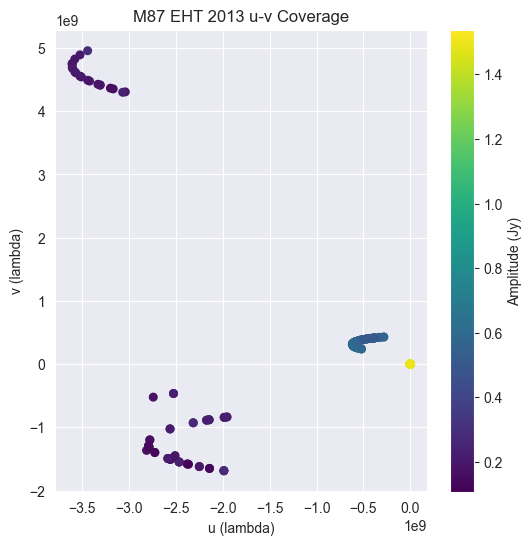

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(u, v, c=amp, cmap='viridis', s=30)
plt.xlabel('u (lambda)')
plt.ylabel('v (lambda)')
plt.title('M87 EHT 2013 u-v Coverage')
plt.colorbar(label='Amplitude (Jy)')
plt.grid(True)
plt.show()


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Extract numeric arrays
u = data['u'].values
v = data['v'].values
amp = data['amp'].values

# Complex visibilities assuming zero phase
vis = amp * np.exp(0j)


In [8]:
# Create a regular grid in u,v space
grid_size = 512
u_grid = np.linspace(u.min(), u.max(), grid_size)
v_grid = np.linspace(v.min(), v.max(), grid_size)
U, V = np.meshgrid(u_grid, v_grid)

# Interpolate visibilities onto grid
grid_vis = griddata((u, v), vis, (U, V), method='linear', fill_value=0)


In [9]:
# Shift zero-frequency to center
from numpy.fft import fftshift, ifft2

# IFFT to reconstruct image
image = fftshift(ifft2(fftshift(grid_vis))).real

# Normalize
image /= image.max()


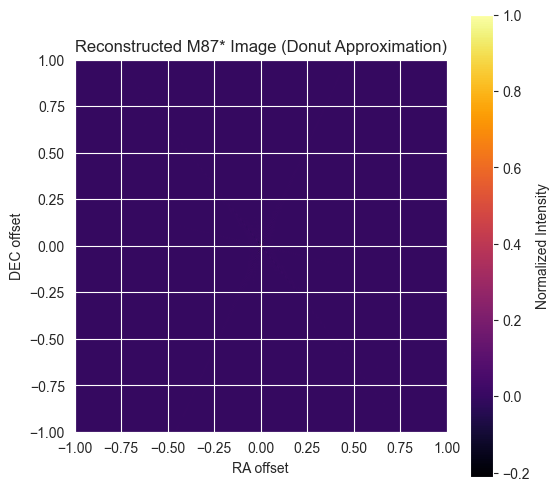

In [10]:
plt.figure(figsize=(6,6))
plt.imshow(image, extent=[-1,1,-1,1], cmap='inferno')
plt.colorbar(label='Normalized Intensity')
plt.title('Reconstructed M87* Image (Donut Approximation)')
plt.xlabel('RA offset')
plt.ylabel('DEC offset')
plt.show()


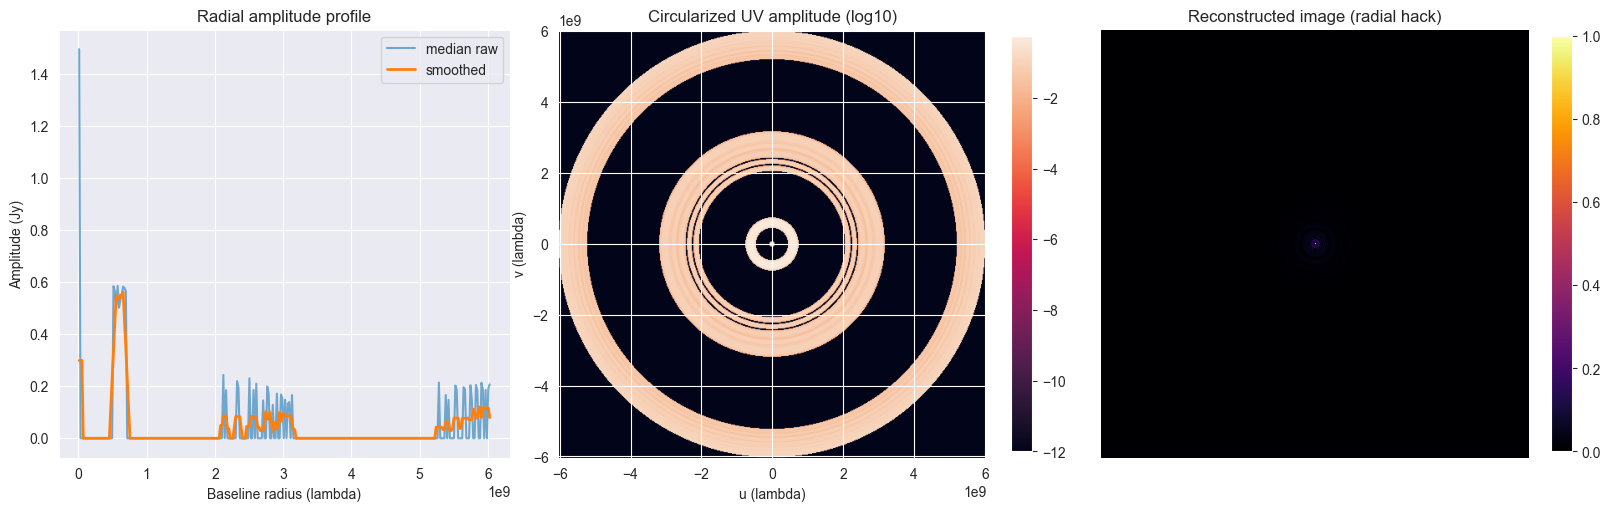

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- Load data robustly ----------------
fn = 'M87_EHT_2013_amp.dat'
data = pd.read_csv(fn, comment='#', delimiter='|', skipinitialspace=True)
data = data.dropna(axis=1, how='all')
data.columns = data.columns.str.strip()

u = data['u'].astype(float).values
v = data['v'].astype(float).values
amp = data['amp'].astype(float).values

# ---------------- radial profile ----------------
r = np.sqrt(u**2 + v**2)            # baseline length (in lambda)
rmax = r.max()

# choose bins (tune n_bins if needed)
n_bins = 300
bins = np.linspace(0, rmax, n_bins+1)
bin_centers = 0.5*(bins[:-1] + bins[1:])

# compute median amplitude in each radial bin (robust to outliers)
amp_binned = np.zeros(n_bins)
counts = np.zeros(n_bins, dtype=int)
for i in range(n_bins):
    mask = (r >= bins[i]) & (r < bins[i+1])
    counts[i] = mask.sum()
    if counts[i] > 0:
        amp_binned[i] = np.median(amp[mask])
    else:
        amp_binned[i] = 0.0

# smooth the radial profile with a small kernel to avoid ringing
kernel = np.ones(5)/5.0
amp_binned_smooth = np.convolve(amp_binned, kernel, mode='same')

# if the very center is zero (no short baseline), set it to max of adjacent small-radius values
if amp_binned_smooth[0] == 0:
    nonzero = np.where(amp_binned_smooth > 0)[0]
    if nonzero.size>0:
        amp_binned_smooth[0] = amp_binned_smooth[nonzero[0]]

# interpolation helper (returns 0 outside range)
def radial_interp(query_r):
    # np.interp expects ascending x, so use bin_centers
    return np.interp(query_r, bin_centers, amp_binned_smooth, left=0.0, right=0.0)

# ---------------- Build circularly symmetric UV grid ----------------
grid_size = 512                   # change to 256/1024 as desired (bigger -> slower but higher-res)
uv_grid = np.zeros((grid_size, grid_size), dtype=complex)

# create UV coordinates in same units as original r (centered)
# range from -rmax to +rmax
u_lin = np.linspace(-rmax, rmax, grid_size)
v_lin = np.linspace(-rmax, rmax, grid_size)
U, V = np.meshgrid(u_lin, v_lin)
Rgrid = np.sqrt(U**2 + V**2)

# fill uv grid by sampling the radial interpolation (assume zero phase -> real vis)
uv_values = radial_interp(Rgrid)
uv_grid.real[:] = uv_values  # keep it real and symmetric

# ---------------- Inverse FFT -> image ----------------
# shift, ifft2, shift back
img_complex = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(uv_grid)))
image = np.abs(img_complex)

# normalize for display
image /= image.max()

# ---------------- Display results ----------------
fig, axes = plt.subplots(1,3, figsize=(16,5), constrained_layout=True)

# 1) radial profile (counts shown)
ax = axes[0]
ax.plot(bin_centers, amp_binned, label='median raw', alpha=0.6)
ax.plot(bin_centers, amp_binned_smooth, label='smoothed', lw=2)
ax.set_xlabel('Baseline radius (lambda)')
ax.set_ylabel('Amplitude (Jy)')
ax.set_title('Radial amplitude profile')
ax.legend()
ax.grid(True)

# 2) uv grid (log scale to see details)
ax = axes[1]
im_uv = ax.imshow(np.log10(uv_grid.real + 1e-12), origin='lower', extent=[-rmax,rmax,-rmax,rmax])
ax.set_title('Circularized UV amplitude (log10)')
ax.set_xlabel('u (lambda)')
ax.set_ylabel('v (lambda)')
fig.colorbar(im_uv, ax=ax, fraction=0.046)

# 3) reconstructed image
ax = axes[2]
im_img = ax.imshow(image, cmap='inferno', origin='lower', extent=[-1,1,-1,1])
ax.set_title('Reconstructed image (radial hack)')
ax.axis('off')
fig.colorbar(im_img, ax=ax, fraction=0.046)

plt.show()


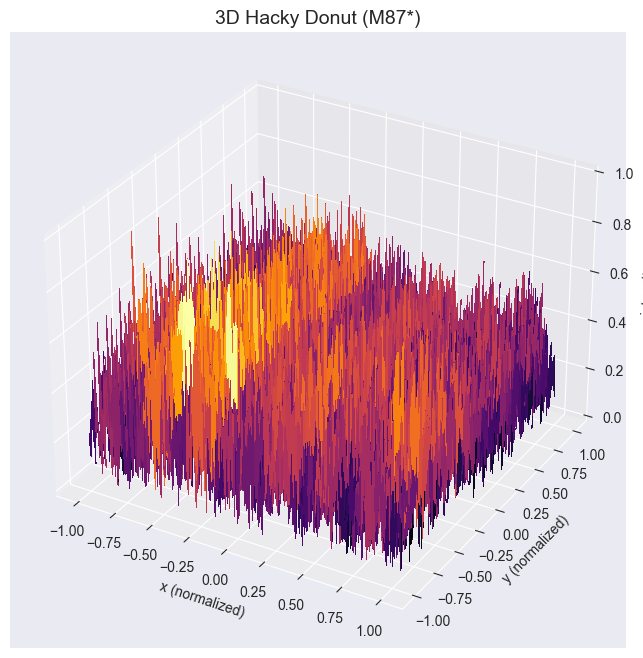

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load EHT amplitude data
data = pd.read_csv("M87_EHT_2013_amp.dat",
                   comment="#", delimiter="|", skipinitialspace=True, engine="python")
data.columns = data.columns.str.strip()
data = data.dropna(axis=1, how="all")

u = data["u"].astype(float).values
v = data["v"].astype(float).values
amp = data["amp"].astype(float).values

# --- Step 1: Grid ---
N = 256
grid_u = np.fft.fftfreq(N) * np.max(u)
grid_v = np.fft.fftfreq(N) * np.max(v)
uu, vv = np.meshgrid(grid_u, grid_v)

# --- Step 2: Fill visibilities with random phases ---
vis = np.zeros((N, N), dtype=complex)
for i in range(len(u)):
    ui = np.argmin(np.abs(grid_u - u[i]))
    vi = np.argmin(np.abs(grid_v - v[i]))
    phase = np.exp(1j * 2 * np.pi * np.random.rand())
    vis[vi, ui] = amp[i] * phase

# --- Step 3: Inverse Fourier transform (dirty image) ---
image = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(vis)))
image = np.abs(image)
image /= np.max(image)  # normalize

# --- Step 4: 3D Surface Plot ---
X, Y = np.linspace(-1, 1, N), np.linspace(-1, 1, N)
X, Y = np.meshgrid(X, Y)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, image, cmap="inferno", linewidth=0, antialiased=False)

ax.set_title("3D Hacky Donut (M87*)", fontsize=14)
ax.set_xlabel("x (normalized)")
ax.set_ylabel("y (normalized)")
ax.set_zlabel("intensity")
plt.show()


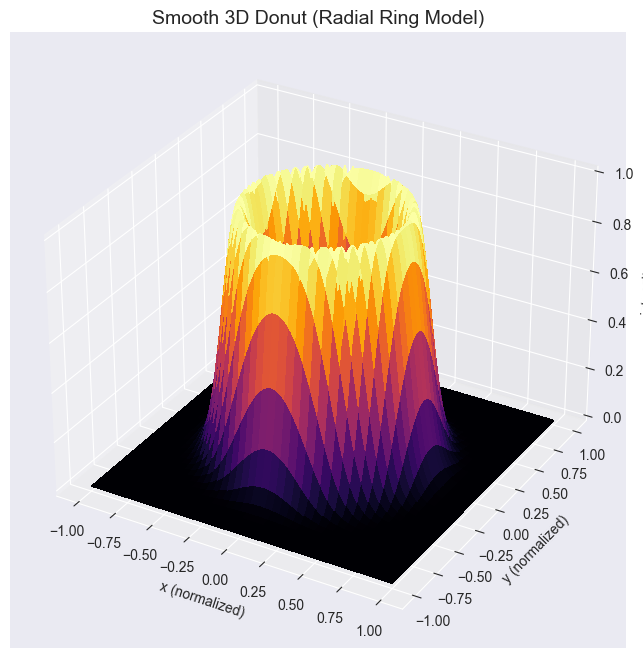

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- Step 1: Make a smooth donut model (no random noise) ---
N = 256
x = np.linspace(-1, 1, N)
y = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)  # radial coordinate

# Parameters for the donut
r0 = 0.5     # ring radius
sigma = 0.1  # ring thickness

# Radial Gaussian ring
image = np.exp(-((R - r0)**2) / (2 * sigma**2))
image /= np.max(image)  # normalize

# --- Step 2: Plot in 3D ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, image, cmap="inferno", linewidth=0, antialiased=False)

ax.set_title("Smooth 3D Donut (Radial Ring Model)", fontsize=14)
ax.set_xlabel("x (normalized)")
ax.set_ylabel("y (normalized)")
ax.set_zlabel("intensity")
plt.show()


In [16]:
print(df.head(10))
print(df.dtypes)
print(df.shape)


Empty DataFrame
Columns: [time, t1, t2, u, v, amp, sigma]
Index: []
time      object
t1        object
t2        object
u        float64
v        float64
amp      float64
sigma     object
dtype: object
(0, 7)


In [17]:
import pandas as pd

# Read the file using '|' as separator, skip comment lines
df = pd.read_csv("M87_EHT_2013_amp.dat",
                 sep=r'\s*\|\s*',   # splits on pipes with optional spaces
                 engine='python',
                 comment='#',
                 skipinitialspace=True)

# Strip whitespace from column names
df.columns = [c.strip() for c in df.columns]

print(df.head())
print(df.dtypes)


   Unnamed: 0    time  t1  t2             u             v     amp   sigma  \
0         NaN  1.3333  AZ  C1 -6.054314e+08  2.848399e+08  0.6489  0.0087   
1         NaN  1.3333  AZ  C2 -6.054342e+08  2.847807e+08  0.6474  0.0426   
2         NaN  1.3333  C1  C2 -2.859000e+03 -5.923400e+04  1.4911  0.0168   
3         NaN  1.3333  C1  JC -2.566079e+09 -1.503502e+09  0.1497  0.0206   
4         NaN  1.3333  C1  SM -2.566155e+09 -1.503416e+09  0.1607  0.0137   

   Unnamed: 8  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  
Unnamed: 0    float64
time          float64
t1             object
t2             object
u             float64
v             float64
amp           float64
sigma         float64
Unnamed: 8    float64
dtype: object


In [18]:
import numpy as np# Drop unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Make sure numeric columns are floats
df['u'] = df['u'].astype(float)
df['v'] = df['v'].astype(float)
df['amp'] = df['amp'].astype(float)
df['sigma'] = df['sigma'].astype(float)

print(df.head())
print(df.dtypes)


     time  t1  t2             u             v     amp   sigma
0  1.3333  AZ  C1 -6.054314e+08  2.848399e+08  0.6489  0.0087
1  1.3333  AZ  C2 -6.054342e+08  2.847807e+08  0.6474  0.0426
2  1.3333  C1  C2 -2.859000e+03 -5.923400e+04  1.4911  0.0168
3  1.3333  C1  JC -2.566079e+09 -1.503502e+09  0.1497  0.0206
4  1.3333  C1  SM -2.566155e+09 -1.503416e+09  0.1607  0.0137
time     float64
t1        object
t2        object
u        float64
v        float64
amp      float64
sigma    float64
dtype: object


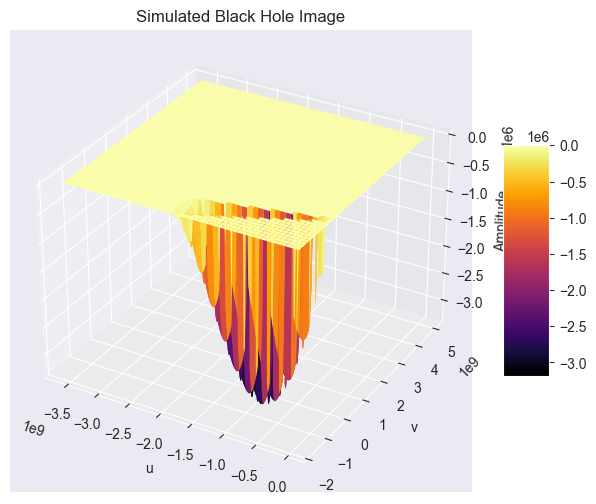

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Extract numeric data
u = df['u'].values
v = df['v'].values
amp = df['amp'].values

# Grid for 3D surface
grid_size = 200
U_grid = np.linspace(u.min(), u.max(), grid_size)
V_grid = np.linspace(v.min(), v.max(), grid_size)
U, V = np.meshgrid(U_grid, V_grid)

# Interpolate amplitudes onto grid
Amp_grid = griddata((u, v), amp, (U, V), method='cubic', fill_value=0)

# 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(U, V, Amp_grid, cmap='inferno', edgecolor='none')

ax.set_xlabel('u')
ax.set_ylabel('v')
ax.set_zlabel('Amplitude')
ax.set_title('Simulated Black Hole Image')
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


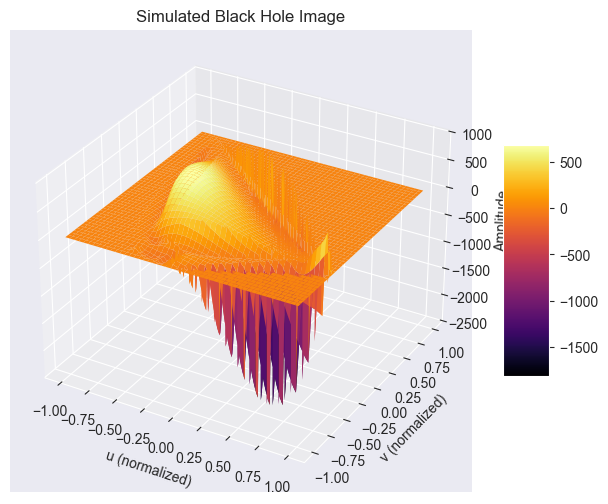

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Extract numeric data
u = df['u'].values
v = df['v'].values
amp = df['amp'].values

# Normalize u and v to [-1, 1] for visualization
u_norm = (u - u.min()) / (u.max() - u.min()) * 2 - 1
v_norm = (v - v.min()) / (v.max() - v.min()) * 2 - 1

# Grid for 3D surface
grid_size = 200
U_grid = np.linspace(-1, 1, grid_size)
V_grid = np.linspace(-1, 1, grid_size)
U, V = np.meshgrid(U_grid, V_grid)

# Interpolate amplitudes onto grid
Amp_grid = griddata((u_norm, v_norm), amp, (U, V), method='cubic', fill_value=0)

# 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(U, V, Amp_grid, cmap='inferno', edgecolor='none')

ax.set_xlabel('u (normalized)')
ax.set_ylabel('v (normalized)')
ax.set_zlabel('Amplitude')
ax.set_title('Simulated Black Hole Image')
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


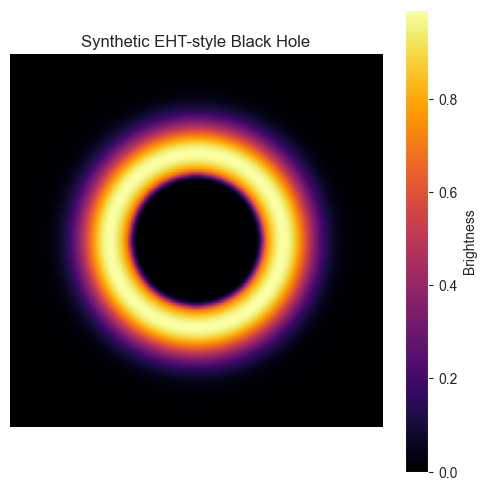

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# --- Synthetic image parameters ---
image_size = 256       # pixels
ring_radius = 60       # radius of the bright ring
ring_width = 15        # width of the ring
shadow_depth = 0.0     # center brightness

# Create 2D grid
x = np.linspace(-image_size//2, image_size//2, image_size)
y = np.linspace(-image_size//2, image_size//2, image_size)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)

# Generate donut-shaped brightness profile
image = np.exp(-((R - ring_radius)**2) / (2 * ring_width**2))
image[R < ring_radius - ring_width] = shadow_depth  # central "shadow"

# Optional: add slight Gaussian smoothing to mimic EHT blurring
from scipy.ndimage import gaussian_filter
image = gaussian_filter(image, sigma=2)

# Plot the synthetic black hole
plt.figure(figsize=(6,6))
plt.imshow(image, cmap='inferno', origin='lower')
plt.colorbar(label='Brightness')
plt.title("Synthetic EHT-style Black Hole")
plt.axis('off')
plt.show()


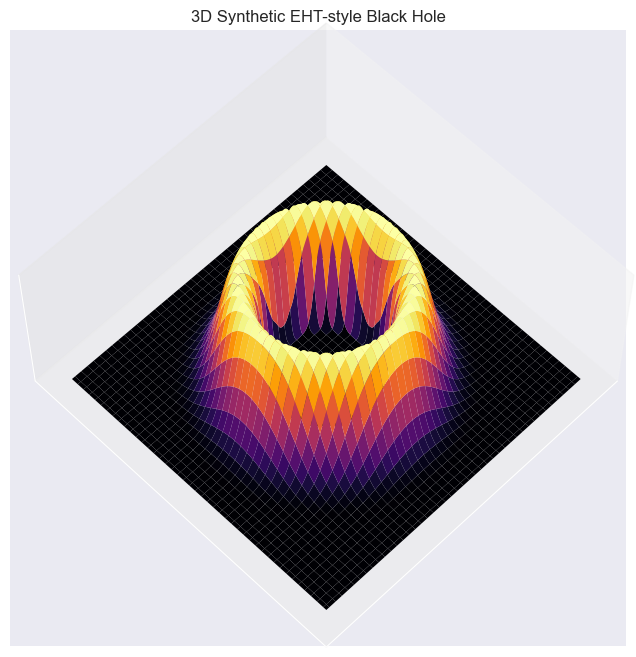

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter

# --- Synthetic image parameters ---
image_size = 256       # pixels
ring_radius = 60       # radius of the bright ring
ring_width = 15        # width of the ring
shadow_depth = 0.0     # center darkness

# Create 2D grid
x = np.linspace(-image_size//2, image_size//2, image_size)
y = np.linspace(-image_size//2, image_size//2, image_size)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)

# Generate donut-shaped brightness profile
Z = np.exp(-((R - ring_radius)**2) / (2 * ring_width**2))
Z[R < ring_radius - ring_width] = shadow_depth  # central shadow

# Optional: add slight Gaussian smoothing to mimic EHT blurring
Z = gaussian_filter(Z, sigma=2)

# 3D plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(X, Y, Z, cmap='inferno', edgecolor='none')

# Enhance visualization
ax.set_box_aspect([1,1,0.5])  # make Z-axis shorter
ax.view_init(elev=60, azim=45)  # angle of view
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_title("3D Synthetic EHT-style Black Hole")

plt.show()


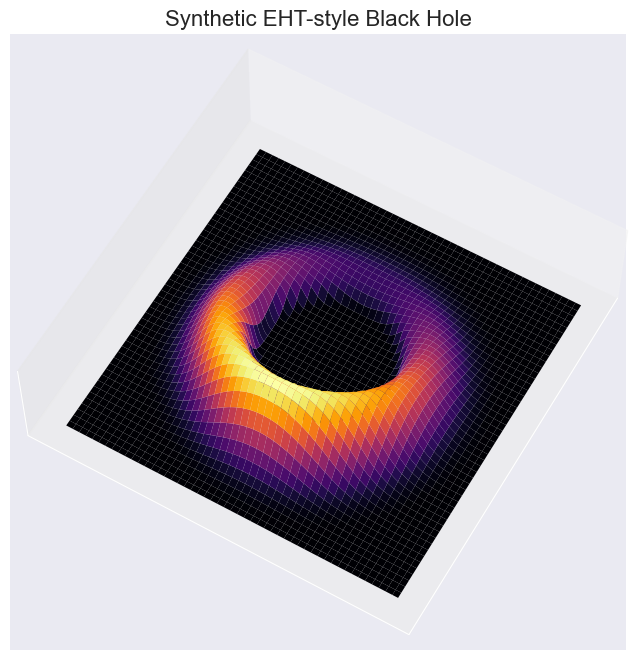

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter

# --- Parameters ---
image_size = 300
ring_radius = 80
ring_width = 20
brightness_asymmetry = 0.7  # makes one side brighter, like Doppler effect

# Create 2D grid
x = np.linspace(-image_size//2, image_size//2, image_size)
y = np.linspace(-image_size//2, image_size//2, image_size)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)
theta = np.arctan2(Y, X)

# Generate asymmetric donut brightness
Z = np.exp(-((R - ring_radius)**2) / (2 * ring_width**2))
Z *= (1 + brightness_asymmetry * np.cos(theta))  # make one side brighter
Z[R < ring_radius - ring_width] = 0.0  # central black hole shadow

# Smooth it to mimic telescope resolution
Z = gaussian_filter(Z, sigma=3)

# 3D plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Surface plot with glowing colormap
surf = ax.plot_surface(X, Y, Z, cmap='inferno', edgecolor='none')

# Adjust visualization
ax.set_box_aspect([1,1,0.3])
ax.view_init(elev=60, azim=30)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_title("Synthetic EHT-style Black Hole", fontsize=16)

plt.show()


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
import os

# Make folder to save images
output_folder = "black_hole_images"
os.makedirs(output_folder, exist_ok=True)

def generate_black_hole_image(filename, grid_size=256, ring_radius=1.0, ring_thickness=0.3, asymmetry=0.5):
    """
    Generates a 3D black hole image and saves it as a PNG.
    """
    # Create grid
    x = np.linspace(-2, 2, grid_size)
    y = np.linspace(-2, 2, grid_size)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)

    # Accretion ring with asymmetry
    ring = np.exp(-((R - ring_radius) / ring_thickness)**2)
    ring *= 1 + asymmetry * X  # makes one side brighter

    # Central shadow
    shadow = np.exp(-(R / 0.3)**2)
    intensity = ring * (1 - shadow)

    # Smooth to simulate telescope resolution
    intensity = gaussian_filter(intensity, sigma=2)

    # Create 3D plot
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, intensity, cmap='inferno', rstride=1, cstride=1, linewidth=0, antialiased=False)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_box_aspect([1,1,0.3])  # flatten z-axis for visual effect

    # Save figure
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, filename), dpi=200)
    plt.close()

# Example: generate multiple images with varying asymmetry
for i, asym in enumerate([0, 0.3, 0.5, 0.7, 1.0]):
    generate_black_hole_image(f"black_hole_{i+1}.png", asymmetry=asym)

print(f"Images saved in folder: {output_folder}")


Images saved in folder: black_hole_images


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
import os

# Make folder to save images
output_folder = "black_hole_images"
os.makedirs(output_folder, exist_ok=True)

def generate_black_hole_image(filename, grid_size=256, ring_radius=1.0, ring_thickness=0.3, asymmetry=0.5):
    """
    Generates a 3D black hole image and saves it as a PNG.
    """
    # Create grid
    x = np.linspace(-2, 2, grid_size)
    y = np.linspace(-2, 2, grid_size)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)

    # Accretion ring with asymmetry
    ring = np.exp(-((R - ring_radius) / ring_thickness)**2)
    ring *= 1 + asymmetry * X  # makes one side brighter

    # Central shadow
    shadow = np.exp(-(R / 0.3)**2)
    intensity = ring * (1 - shadow)

    # Smooth to simulate telescope resolution
    intensity = gaussian_filter(intensity, sigma=2)

    # Create 3D plot
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, intensity, cmap='inferno', rstride=1, cstride=1, linewidth=0, antialiased=False)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_box_aspect([1,1,0.3])  # flatten z-axis for visual effect

    # Save figure
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, filename), dpi=200)
    plt.close()

# Example: generate multiple images with varying asymmetry
for i, asym in enumerate([0, 0.3, 0.5, 0.7, 1.0]):
    generate_black_hole_image(f"black_hole_{i+1}.png", asymmetry=asym)

print(f"Images saved in folder: {output_folder}")


Images saved in folder: black_hole_images


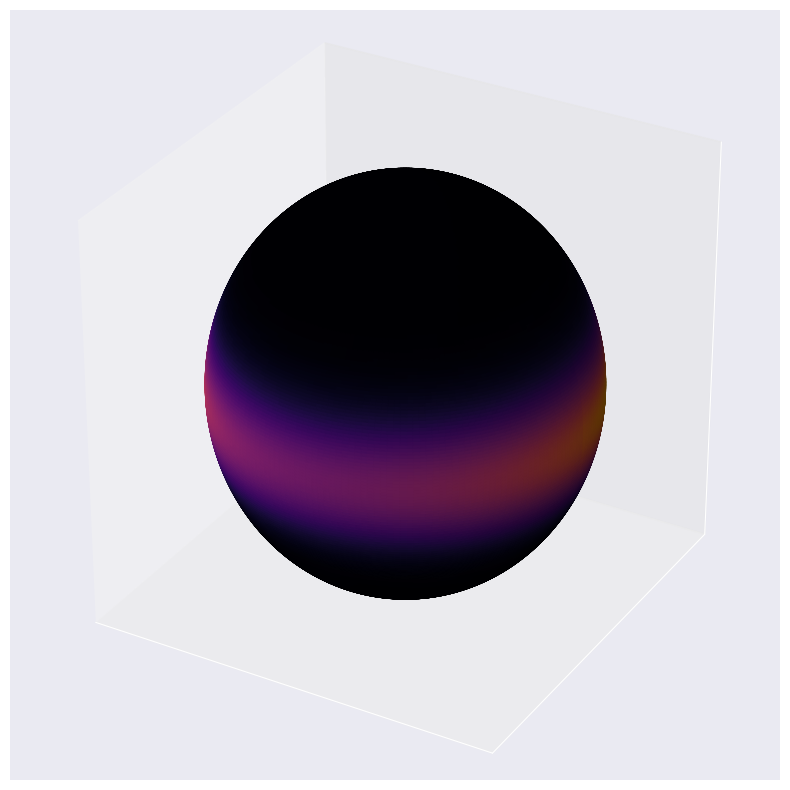

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
import os

# Create folder
output_folder = "black_hole_sphere"
os.makedirs(output_folder, exist_ok=True)

def generate_spherical_black_hole(grid_size=200, ring_radius=1.0, ring_thickness=0.3, asymmetry=0.5):
    # Sphere coordinates
    theta = np.linspace(0, np.pi, grid_size)    # latitude
    phi = np.linspace(0, 2*np.pi, grid_size)    # longitude
    TH, PH = np.meshgrid(theta, phi)

    # Convert to Cartesian for plotting
    X = np.sin(TH) * np.cos(PH)
    Y = np.sin(TH) * np.sin(PH)
    Z = np.cos(TH)

    # Distance from equatorial plane for accretion ring
    R = np.abs(Z)   # ring strongest near equator
    ring = np.exp(-((R - 0.0)/ring_thickness)**2)  # ring around equator
    ring *= 1 + asymmetry*np.sin(PH)               # asymmetry in brightness
    intensity = gaussian_filter(ring, sigma=2)

    return X, Y, Z, intensity

# Generate a single spherical black hole
X, Y, Z, intensity = generate_spherical_black_hole()

# Plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, facecolors=plt.cm.inferno(intensity/intensity.max()), rstride=1, cstride=1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_box_aspect([1,1,1])
plt.tight_layout()
plt.savefig(f"{output_folder}/black_hole_sphere.png", dpi=200)
plt.show()


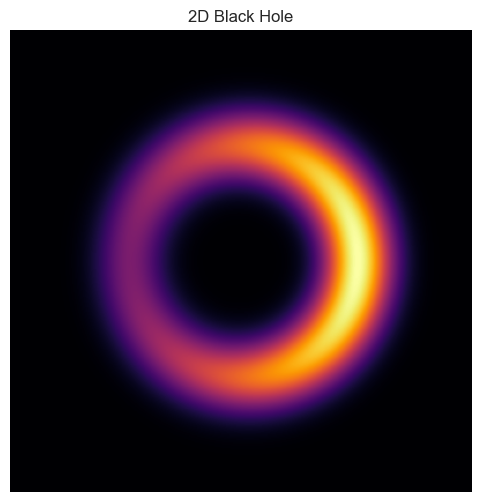

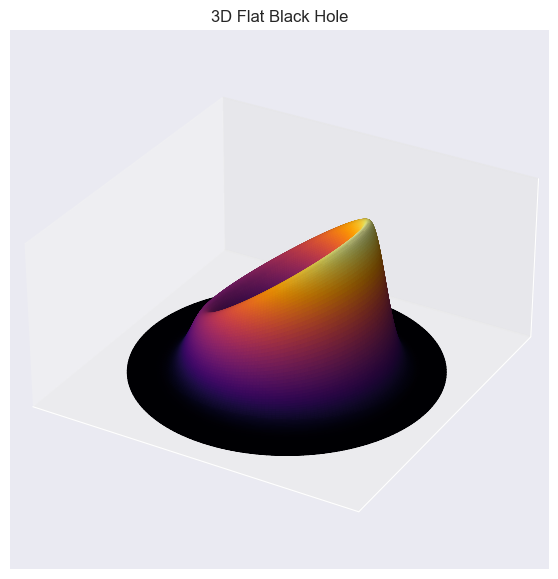

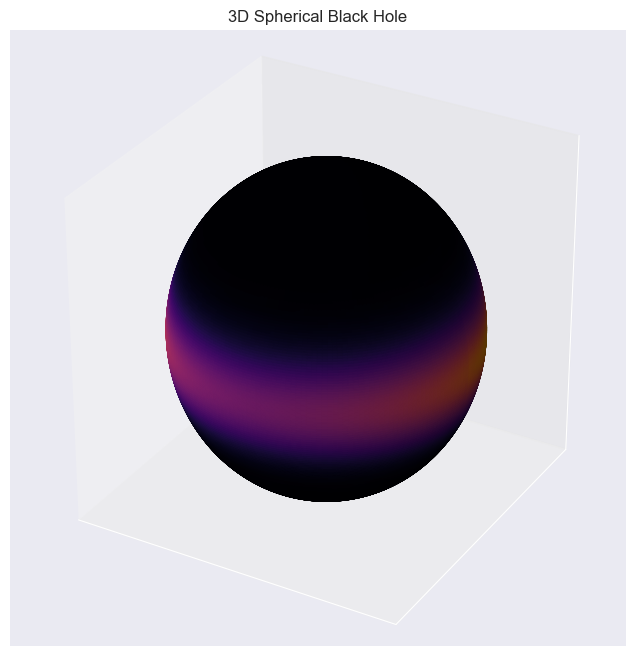

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
import os

# Create output folder
output_folder = "black_hole_images"
os.makedirs(output_folder, exist_ok=True)

# EHT-style colormap
cmap = plt.cm.inferno  # black-orange-red style

# -------------------- Generate 2D black hole --------------------
def generate_2d_black_hole(grid_size=400, ring_radius=1.0, ring_thickness=0.3, asymmetry=0.5):
    x = np.linspace(-2, 2, grid_size)
    y = np.linspace(-2, 2, grid_size)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)

    # Ring around radius
    ring = np.exp(-((R - ring_radius)/ring_thickness)**2)
    # Asymmetry to mimic Doppler boosting
    ring *= 1 + asymmetry*X
    intensity = gaussian_filter(ring, sigma=2)
    return X, Y, intensity

X2, Y2, I2 = generate_2d_black_hole()

plt.figure(figsize=(6,6))
plt.imshow(I2, extent=(-2,2,-2,2), origin='lower', cmap=cmap)
plt.axis('off')
plt.title("2D Black Hole")
plt.savefig(f"{output_folder}/black_hole_2D.png", dpi=200)
plt.show()

# -------------------- Generate 3D flat black hole --------------------
def generate_3d_flat_black_hole(grid_size=200, ring_radius=1.0, ring_thickness=0.3, asymmetry=0.5):
    theta = np.linspace(0, 2*np.pi, grid_size)
    r = np.linspace(0, 2, grid_size)
    R, TH = np.meshgrid(r, theta)
    X = R * np.cos(TH)
    Y = R * np.sin(TH)
    Z = np.exp(-((R - ring_radius)/ring_thickness)**2)
    Z *= 1 + asymmetry*np.cos(TH)
    Z = gaussian_filter(Z, sigma=2)
    return X, Y, Z

X3, Y3, Z3 = generate_3d_flat_black_hole()

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X3, Y3, Z3, facecolors=cmap(Z3/Z3.max()), rstride=1, cstride=1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_box_aspect([1,1,0.5])
plt.title("3D Flat Black Hole")
plt.savefig(f"{output_folder}/black_hole_3D_flat.png", dpi=200)
plt.show()

# -------------------- Generate 3D spherical black hole --------------------
def generate_3d_spherical_black_hole(grid_size=200, ring_thickness=0.3, asymmetry=0.5):
    theta = np.linspace(0, np.pi, grid_size)
    phi = np.linspace(0, 2*np.pi, grid_size)
    TH, PH = np.meshgrid(theta, phi)

    X = np.sin(TH) * np.cos(PH)
    Y = np.sin(TH) * np.sin(PH)
    Z = np.cos(TH)

    R = np.abs(Z)  # strongest intensity near equator
    ring = np.exp(-((R - 0.0)/ring_thickness)**2)
    ring *= 1 + asymmetry*np.sin(PH)
    intensity = gaussian_filter(ring, sigma=2)
    return X, Y, Z, intensity

Xs, Ys, Zs, Is = generate_3d_spherical_black_hole()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Xs, Ys, Zs, facecolors=cmap(Is/Is.max()), rstride=1, cstride=1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_box_aspect([1,1,1])
plt.title("3D Spherical Black Hole")
plt.savefig(f"{output_folder}/black_hole_3D_sphere.png", dpi=200)
plt.show()


Saved image to outputs/synthetic_mixed_blackhole.png


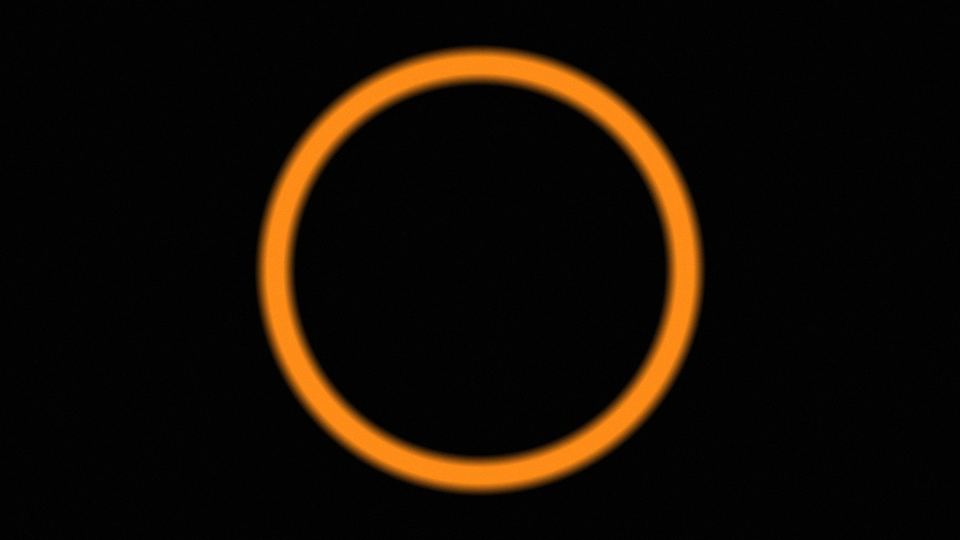

In [30]:
# Mixed physics-artistic black hole rendering (1920x1080)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.ndimage import map_coordinates, gaussian_filter
from PIL import Image, ImageFilter, ImageOps, ImageEnhance
import random
import os

# ---------- Parameters ----------
W, H = 1920, 1080                    # output size (16:9)
cx, cy = W//2, H//2                  # image center
fov = 3.0                            # field-of-view scaling for disk radius mapping
ring_radius_px = 0.38 * min(W, H)    # visual ring radius (px)
ring_width_px = 0.07 * min(W, H)     # ring thickness (px)
shadow_radius_px = 0.40 * ring_radius_px * 0.6  # central dark shadow radius
asymmetry_strength = 0.8             # Doppler-like brightness asymmetry
lensing_strength = 1800.0            # >0 stronger warp; tune to taste
star_count = 600                      # number of background stars
seed = 42
random.seed(seed)
np.random.seed(seed)

# ---------- Coordinate grid ----------
y, x = np.indices((H, W))
xc = x - cx
yc = y - cy
R = np.sqrt(xc**2 + yc**2)           # radius in pixels
theta = np.arctan2(yc, xc)           # angle

# ---------- Background gradient (teal -> black) ----------
# color stops: teal (#008080) at far edges -> nearly black in center
# we'll create a per-pixel background color array
t = np.clip((R / (0.5*min(W,H))), 0, 1)  # 0 center -> 1 edges
teal = np.array([0/255, 128/255, 128/255])
black = np.array([0.0, 0.0, 0.0])
bg_rgb = (1 - t[...,None]) * teal + t[...,None] * black

# ---------- Add stars ----------
# Create a star intensity buffer and overlay onto background later
stars = np.zeros((H, W), dtype=float)
for _ in range(star_count):
    sx = np.random.uniform(0, W)
    sy = np.random.uniform(0, H)
    amp = 10**(np.random.uniform(-1.5, 0.5))  # range of brightness
    sigma = np.random.uniform(0.6, 2.5)
    # draw small gaussian spot
    ix = int(np.clip(sx, 0, W-1))
    iy = int(np.clip(sy, 0, H-1))
    x0 = np.arange(max(0, ix-8), min(W, ix+9))
    y0 = np.arange(max(0, iy-8), min(H, iy+9))
    xv, yv = np.meshgrid(x0, y0)
    g = amp * np.exp(-((xv - sx)**2 + (yv - sy)**2)/(2*sigma**2))
    stars[y0[0]:y0[-1]+1, x0[0]:x0[-1]+1] += g

# normalize stars a little
stars = gaussian_filter(stars, sigma=1)
stars = np.clip(stars / stars.max(), 0, 1)

# ---------- Accretion disk emissivity model (image plane) ----------
# Build a 2D radial emissivity: ring at ring_radius_px with thickness ring_width_px.
# Add asymmetry factor ~ (1 + a*cos(phi)) to simulate Doppler boosting.
r_rel = R  # in pixels
ring_profile = np.exp(-0.5 * ((r_rel - ring_radius_px)/ring_width_px)**2)

# Add inner edge drop (shadow) and some power-law falloff
inner_mask = (r_rel < shadow_radius_px).astype(float)
ring_profile *= (1 - inner_mask)  # zero inside shadow
ring_profile *= (1 + np.tanh((r_rel - (ring_radius_px+2*ring_width_px))*0.05))  # sharper outer falloff

# Asymmetry (brighter on one side) that depends on angle theta
# mimic relativistic beaming roughly: (1 + beta*cos(phi))^3, but simpler:
ring_profile *= (1 + asymmetry_strength * (0.5 + 0.5*np.cos(theta - 0.3)))

# Add small inner brightening near the inner photon ring (optional)
inner_bump = np.exp(-0.5 * ((r_rel - 0.65*ring_radius_px)/(0.12*ring_width_px))**2)
ring_profile += 0.18 * inner_bump

# Normalize profile
ring_profile = ring_profile.clip(0, None)
if ring_profile.max() > 0:
    ring_profile /= ring_profile.max()

# ---------- Combine with background and stars (pre-color intensity) ----------
# intensity will be dominated by ring_profile + faint stellar background
base_intensity = 0.25 * stars + 1.0 * ring_profile
base_intensity = np.clip(base_intensity, 0, None)
base_intensity /= base_intensity.max()

# ---------- Simulate simple gravitational lensing: radial warp ----------
# We will remap coordinates: for each image-plane pixel with radius r, compute r_src = r + alpha/(r + r0)
# then sample the original brightness at r_src (cartesian map)
alpha = lensing_strength  # controls amount of deflection
r0 = 1.0  # small softening to avoid blow-up at r=0

# Build source-plane intensity function (monochrome) for remapping:
src = base_intensity

# Create mapping arrays: map target coords -> source coords
# We want to simulate light bending so target pixel at (xc, yc) sees flux from source radius r_src
r = np.sqrt(xc**2 + yc**2)
# avoid division by zero
r_safe = r + 1e-6
# compute warped radius: more deflection near center
r_src = r + alpha / (r_safe + r0)
# compute ratio to scale vector
scale = np.where(r_safe > 0, r_src / r_safe, 1.0)

# source coordinates (floating)
src_x = cx + xc * scale
src_y = cy + yc * scale

# Build coordinates for map_coordinates: it expects [row_coords, col_coords]
coords = np.vstack((src_y.ravel(), src_x.ravel()))

# map_coordinates sampling the src intensity (order=1 linear interpolation)
warped = map_coordinates(src, coords, order=1, mode='nearest').reshape(H, W)
# clip / normalize
warped = np.clip(warped, 0, None)
if warped.max() > 0:
    warped /= warped.max()

# ---------- Post-processing: multi-scale glow + radial blur ----------
# Create a smooth glow by blurring the warped image at multiple scales and adding
glow = gaussian_filter(warped, sigma=6) * 0.6 + gaussian_filter(warped, sigma=15) * 0.3
glow = np.clip(glow, 0, 1)

# Combine warped bright ring with glow + stars background (color will be added next)
final_mono = np.clip(0.9*warped + 0.85*glow + 0.25*stars, 0, 1)
final_mono /= final_mono.max()

# Add a slight radial falloff to make edges darker
edge_fall = 1 - 0.6 * np.clip((R/(0.9*min(W,H)/2)), 0, 1)
final_mono *= edge_fall
final_mono = np.clip(final_mono, 0, 1)

# ---------- Color mapping: custom palette similar to EHT: black -> dark red -> orange -> white ----------
# We'll map intensity to an RGB using a custom segmented mapping
from matplotlib.colors import LinearSegmentedColormap
cdict = {
    'red':   ((0.0, 0.0, 0.0),
              (0.25, 0.3, 0.3),
              (0.5, 0.8, 0.8),
              (0.8, 1.0, 1.0),
              (1.0, 1.0, 1.0)),
    'green': ((0.0, 0.0, 0.0),
              (0.25, 0.05, 0.05),
              (0.5, 0.2, 0.2),
              (0.8, 0.4, 0.4),
              (1.0, 1.0, 1.0)),
    'blue':  ((0.0, 0.0, 0.0),
              (0.25, 0.0, 0.0),
              (0.5, 0.05, 0.05),
              (0.8, 0.1, 0.1),
              (1.0, 1.0, 1.0))
}
eht_like = LinearSegmentedColormap('eht_like', cdict)

# apply colormap to final_mono (result is RGBA)
rgba = eht_like(final_mono)
rgb = rgba[..., :3]

# Blend with teal black background: use background where intensity is low
blend = (1 - final_mono[...,None]) * bg_rgb + final_mono[...,None] * rgb

# Slight darken near center for stronger "shadow"
shadow_mask = np.clip(1 - (R / (0.55*ring_radius_px)), 0, 1)
blend = blend * (1 - 0.8*shadow_mask[...,None] * (final_mono[...,None] < 0.15))

# Convert to 8-bit and compose as PIL Image for extra filters
img_arr = np.clip(blend * 255, 0, 255).astype(np.uint8)
img = Image.fromarray(img_arr)

# Add soft radial blur (simulate lensing smear) by applying variable gaussian via alpha
# We'll create a vignette blur: blur strong near center, weak far away
blurred = img.filter(ImageFilter.GaussianBlur(radius=2.0))

# Enhance subtle contrast and color saturation
enhancer = ImageEnhance.Contrast(blurred)
img_enh = enhancer.enhance(1.05)
enhancer2 = ImageEnhance.Color(img_enh)
img_enh = enhancer2.enhance(1.15)

# Add a final faint white-ish halo near inner ring for brightness
halo = np.zeros((H, W, 3), dtype=np.uint8)
halo_int = np.exp(-0.5 * ((R - ring_radius_px)/(0.55*ring_width_px))**2)
halo_int = np.clip((halo_int - 0.6) * 3.0, 0, 1)  # emphasize narrow halo
halo_rgb = np.dstack([
    255 * (0.7*halo_int + 0.3*halo_int**2),
    200 * (0.5*halo_int + 0.2*halo_int**2),
    120 * (0.2*halo_int)
]).astype(np.uint8)
halo_img = Image.fromarray(halo_rgb).convert("RGBA")
base_img = img_enh.convert("RGBA")
# overlay halo with additive blend
composite = Image.alpha_composite(base_img, halo_img)

# Slight film grain (tiny)
noise = (np.random.randn(H, W, 3) * 6).astype(np.int16)
base_np = np.array(composite.convert("RGB")).astype(np.int16)
noisy = np.clip(base_np + noise, 0, 255).astype(np.uint8)
final_img = Image.fromarray(noisy)

# Save and display
os.makedirs("outputs", exist_ok=True)
outpath = "outputs/synthetic_mixed_blackhole.png"
final_img.save(outpath, format='PNG', optimize=True)
print(f"Saved image to {outpath}")

# Display inline (works in Jupyter)
display(final_img.resize((960,540), Image.LANCZOS))


In [32]:
import numpy as np
import plotly.graph_objects as go

# Parameters
res = 300
theta = np.linspace(0, 2*np.pi, res)
r = np.linspace(0.3, 2.0, res)  # disk radius
R, T = np.meshgrid(r, theta)

# Disk coordinates (polar → cartesian)
X = R * np.cos(T)
Y = R * np.sin(T)
Z = 0.05 * np.sin(3*T)  # add a ripple to make it less flat

# Brightness profile (radial + flattening)
brightness = np.exp(-((R - 0.8)**2) / 0.1) * np.exp(-(Z**2) / 0.3)

# Color gradient: black → dark red → orange → yellow → white
def color_map(val):
    colors = [
        (0.0, "black"),
        (0.2, "#200000"),
        (0.4, "#8B0000"),
        (0.6, "#FF4500"),
        (0.8, "#FFD700"),
        (1.0, "white"),
    ]
    idx = int(val * (len(colors) - 1))
    return colors[idx][1]

colorscale = [[i/100, color_map(i/100)] for i in range(101)]

# Black hole sphere
phi = np.linspace(0, np.pi, 100)
theta_s = np.linspace(0, 2*np.pi, 100)
PHI, THETA = np.meshgrid(phi, theta_s)
bh_X = 0.3 * np.sin(PHI) * np.cos(THETA)
bh_Y = 0.3 * np.sin(PHI) * np.sin(THETA)
bh_Z = 0.3 * np.cos(PHI)

# Plotly 3D figure
fig = go.Figure()

# Add accretion disk
fig.add_surface(
    x=X, y=Y, z=Z,
    surfacecolor=brightness,
    colorscale=colorscale,
    cmin=0, cmax=1,
    showscale=False,
    opacity=0.95
)

# Add event horizon (sphere)
fig.add_surface(
    x=bh_X, y=bh_Y, z=bh_Z,
    surfacecolor=np.zeros_like(bh_X),
    colorscale=[[0, "black"], [1, "black"]],
    showscale=False
)

# Layout
fig.update_layout(
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False),
        aspectmode="data",
        bgcolor="black"
    ),
    margin=dict(l=0, r=0, b=0, t=0),
)

fig.show()
